In [18]:
""" This script is used to compute and plot the time deltas of the CMS ECAL prototype from the ETH group at the CERN Prevessin site.
The mainly used functions to call from outside the script are down below: run_time_delta_computation, statistics_plot, variation_plot, and variation_statistics.

General usage workflow:
1. Use run_time_delta_computation on all the measurement runs.
2. Use statistics_plot on the runs to see their statistics.
3. Use variation_plot to plot the behavior of a measurement batch (multiple runs) with respect to the variation within the measurement (for example temperature).
4. Use variation_statistics to visualize the statistics of the measurement batches.
"""

""" Imports """

import uproot
import numpy as np
import pandas as pd
import glob
import os
import h5py
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from decimal import *
from pathlib import Path


""" Global Variables """

save_folder_global = 'Synchronisation January 2022' # Processed data from time delta computation will be stored in a folder named like this. 
                                        # The data from January 2022 is in 'Synchronisation January 2022'
raw_data_folder_global = '/eos/home-s/spigazzi/Lab21/data/Reco/' # Raw data is stored here
variation_save_folder_global = 'Variation Stats ' # Variation plots are saved here
split_name = 'Merged' # Needed for legacy support, namely to be able to run the statistics_plot and variation plot functions 
                    # on the data files from January 2022 with 'Merged in their name'. Obsolete otherwise, split_name could be removed everywhere 

numbers = ['1', '2', '3', '4', '5'] # The five channels on each board
letters = ['A', 'B', 'D', 'E'] # TODO: Add Back 'C' when board 20 (middle board) is back. It was out of order in January 2022

X = numbers.copy() # Used for colormesh plots
Y = letters.copy()
X.insert(0, '0')
Y.insert(0, '0')

channel_names = ['A1', 'A2', 'A3', 'A4', 'A5', 
                 'B1', 'B2', 'B3', 'B4', 'B5', # TODO: Add C when board C returns
                 'D1', 'D2', 'D3', 'D4', 'D5',
                 'E1', 'E2', 'E3', 'E4', 'E5']

plt.rcParams['text.usetex'] = True


""" Helper Functions """

def gaussian(x, *p):
    A, mu, sigma = p
    return A * np.exp(-(x -mu)**2/(2*sigma**2))


def synchroniser(value):
    """ Function to remove the period shift. Collects the scattered peaks separated by integer multiples of the clock period to one large peak """
    clock_period = 6.238 # nanoseconds    
    window_leniency = 0.5 # How far from the center value the synchroniser should start to act. Minimum Value that makes sense physically: 0.5
    if value > 0:
        while value > clock_period * window_leniency:
            value -= clock_period
    else:
        while value < (-clock_period * window_leniency):
            value += clock_period
    return float(Decimal(value) % Decimal(clock_period))


def temperature_conversion(resistance):
    """ Takes resistance in Ohm. Returns temperature calculated from the measured resistance of the temperature sensor reader """
    nominal_resistance = 1000 # in Ohm
    mean_coefficient = 3.91e-3 # in K^-1, for the plantinum resistance thermometer Pt1000
    return (np.abs(resistance - nominal_resistance))/(mean_coefficient * nominal_resistance)


def to_channel_converter(channel_number):
    """ Converts the channel number to the appropriate Channel. For example 7 -> 'B3'. """
    board_counter = 0
    while channel_number > 4:
        board_counter += 1
        channel_number -= 5
    return f'{letters[board_counter]}{numbers[channel_number]}'
    

def compute_time_delta(time, reference_channel_index, run_name, split_name='Merged', plot=True, apply_synchroniser=True):
    """ Computes the time difference (delta) for a given reference channel to all the other channels. 
    Also returns the mu and sigma statistics and their errors."""
    time_pd = pd.DataFrame(time)
    n_channels = len(letters) * 5
    
    time_delta_pd = pd.DataFrame()
    mu_arr = np.zeros(n_channels)
    mu_error_arr = np.zeros(n_channels)
    sigma_arr = np.zeros(n_channels)
    sigma_error_arr = np.zeros(n_channels)
    for i in range(n_channels):
        if i == reference_channel_index:
            continue
            
        reference_time = time_pd.iloc[:,reference_channel_index]
        curr_time = time_pd.iloc[:,i]
        time_delta = reference_time - curr_time

        # Remove period shift from the data
        if apply_synchroniser: 
            time_delta = time_delta.apply(synchroniser)
        
        time_delta = time_delta.multiply(1000)
        
        # Save time deltas for later analysis
        time_delta_pd[f'{i}'] = time_delta

        plt.figure()
        border_size = 2000
        plt.xlim((-border_size,border_size))

        # The fitting process
        hist, bin_edges, _ = plt.hist(time_delta, bins = 1500, label='Time Delta Histogram')
        bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)  
        guess = [np.max(hist), bin_centers[np.argmax(hist)], 300]
        coeff, covar = curve_fit(gaussian, bin_centers, hist, p0=guess)
        mu = coeff[1]
        mu_error = covar[1,1]
        sigma = coeff[2]
        sigma_error = covar[2,2]
        mu_arr[i] = mu
        mu_error_arr[i] = mu_error
        sigma_arr[i] = sigma
        sigma_error_arr[i] = sigma_error
        
        if plot:
            plt.plot(bin_centers, gaussian(bin_centers, *coeff), label='Gaussian Fit')
            plt.axvline(mu, label = f'Mean: {np.around(mu, decimals = 1)} ps', color = 'red')
            sigma_color = 'pink'
            plt.axvline(mu + sigma, label = f'Std Dev: {np.around(sigma, decimals = 1)} ps', color = sigma_color)
            plt.axvline(mu - sigma, color = sigma_color)
            plt.title(f'Reference Channel: {to_channel_converter(reference_channel_index)}, Run: {run_name}, Channel {to_channel_converter(i)}')
            plt.xlabel('Time Delta (ps)')
            plt.ylabel('Occurence (a.u.)')
            plt.legend(loc='best')
            
    plt.show()

    return time_delta_pd, mu_arr.reshape(-1,1), mu_error_arr.reshape(-1,1), sigma_arr.reshape(-1,1), sigma_error_arr.reshape(-1,1)


""" Main functions to run from outside script """

def run_time_delta_computation(run_number, save_folder = save_folder_global, raw_data_folder = raw_data_folder_global):
    """ Computes the time deltas for a run. The splits are merged into a single big run number and the time deltas are saved in an h5 file.
    
    run_number -- (string or int) the number of a run, for example '15484'
    save_folder -- (string) folder where the computed data should be stored
    raw_data_folder -- (string) folder where the raw experiment data is located
    """
    
    # Computation with merged data
    folder =  raw_data_folder + str(int(run_number))
    h = uproot.concatenate({folder+'/*.root' : 'digi'}, allow_missing = True)
    
    run_name = os.path.basename(os.path.normpath(folder))
    print('Run: ', run_name, ' Split: ', split_name)
    run_save = save_folder + '/Run ' + run_name + '/' + split_name + '/'
    Path(run_save).mkdir(parents=True, exist_ok=True)

    for ref_channel in channel_names:       
        ref_idx = h[ref_channel][0]
        time = h['time_max']
        time_pd = pd.DataFrame(time)

        time_delta_data, mu_arr, mu_error_arr, sigma_arr, sigma_error_arr  = compute_time_delta(time, ref_idx, run_name)
        statistics = np.hstack((mu_arr, mu_error_arr, sigma_arr, sigma_error_arr))
        time_delta_data.to_hdf(run_save + f'Time Delta Run {run_name} ref_ch {ref_channel}.h5', key='df', mode='w')
        with h5py.File(run_save + 'Statistics Split ' + split_name + f' ref_ch {ref_channel}.h5', 'w') as hf:
            hf.create_dataset("stats",  data=statistics)
            

def statistics_plot(run_number, save_folder=save_folder_global, raw_data_folder=raw_data_folder_global, skip_mu=False):
    """ Plots mu and sigma as well as their errors for the time deltas of a designated run in a colormesh plot.
    One has to have run the run_time_delta_computation function on the designated run first before using this function.
    
    run_number -- (string or int) The number of a run, for example '15484'
    save_folder -- (string) Folder where the computed data should be stored
    raw_data_folder -- (string) Folder where the raw experiment data is located
    skip_mu == (boolean) If one is not interested in mu, one can skip plotting it
    """
    
    stat_names = ['Mu', 'Mu error', 'Sigma', 'Sigma_error']
    folder =  raw_data_folder + str(int(run_number))
    run_name = os.path.basename(os.path.normpath(folder))
    print('Run: ', run_name, ' Split: ', split_name)
    run_save = save_folder + '/Run ' + str(run_name) + '/' + split_name + '/'
    Path(run_save).mkdir(parents=True, exist_ok=True)

    for k, ref_channel in enumerate(channel_names):
        with h5py.File(run_save + 'Statistics Split ' + split_name + f' ref_ch {ref_channel}.h5', 'r') as hf:
            statistics = hf[f"stats"][:]
            
        for i in range(len(statistics[0,:])):
            if skip_mu and ((i == 0) or (i ==1)):
                continue
                
            plt.figure()
            stat_data = statistics[:,i].reshape(4,5)
            c = plt.pcolormesh(X, Y, stat_data*1000)
            cb = plt.colorbar(c)
            cb.set_label('Deviation over Channels (ps)')
            plt.title(f'{stat_names[i]}, Run: {run_name}, Split: {split_name}, Reference Channel: {ref_channel}')
            plt.show()
        plt.savefig(run_save + f'Stats Colormesh Ref Channel {to_channel_converter(k)}.pdf', dpi = 300)
        

def variation_plot(measurement_name, measurement_date, included_runs, mu_range = 2000, sigma_range = 150, specific_ref_channel='all'):
    """Plots the evolution of the mu and sigma statistics and their errors over a number of runs.
    
    measurement_name -- (string) Title of the measurement, for example power cycle or temperature
    measurement_date -- (string) Date of the measurement. Originally used to distinguish between series of runs, 
                        but the date will not be unique enough for future measurements.
                        Could and should be replaced by a unique identifier, like an ID for a batch of runs.
    included_runs -- (list of strings or ints) List of all the runs to include in our variation plot.
    mu_range -- (number) Maximum and minimum of which mu values will be visible in the plot
    sigma_range -- (number) Maximum and minimum of which sigma values will be visible in the plot
    specific_ref_channel -- (string) If one wants to test the function only for a specific channel, use that channel here, for example 'B3'
    """
    
    save_folder = save_folder_global
    variation_save = variation_save_folder_global + '/' + measurement_name + '/' + measurement_date + '/'
    Path(variation_save).mkdir(parents=True, exist_ok=True)
    
    for q, ref_channel in enumerate(channel_names):
        if specific_ref_channel != 'all':
            q = 0
            if ref_channel != specific_ref_channel:
                continue

        for k, run_name in enumerate(included_runs):
            run_save = save_folder + '/Run ' + str(run_name) + '/' + split_name + '/'
            if k==0:
                with h5py.File(run_save + 'Statistics Split ' + split_name + f' ref_ch {ref_channel}.h5', 'r') as hf:
                    stacked_average_stats = hf[f"stats"][:]
            else:
                with h5py.File(run_save + 'Statistics Split ' + split_name + f' ref_ch {ref_channel}.h5', 'r') as hf:
                    stacked_average_stats = np.dstack((stacked_average_stats, hf[f"stats"][:]))
        stacked_average_stats = stacked_average_stats * 1000

        # In its final form stats_ref_array will have shape (20, 4, 20). The first 20 are the channels looked at, 
        # the 4 are the four stats seen in the comments below, and the last 20 will be the used reference channels.
        if q ==0:
            stats_ref_array = np.array((np.average(stacked_average_stats[:,0,:], axis=1), # Mean of mu
                                        np.std(stacked_average_stats[:,0,:], axis=1), # Std dev of mu
                                        np.average(stacked_average_stats[:,2,:], axis=1), # Mean of Sigma
                                        np.std(stacked_average_stats[:,2,:], axis=1))).T # Std dev of sigma
        else:
            stats_ref_array = np.dstack((stats_ref_array,
                                        np.array((np.average(stacked_average_stats[:,0,:], axis=1), # Mean of mu
                                        np.std(stacked_average_stats[:,0,:], axis=1), # Std dev of mu
                                        np.average(stacked_average_stats[:,2,:], axis=1), # Mean of Sigma
                                        np.std(stacked_average_stats[:,2,:], axis=1))).T # Std dev of sigma
                                        ))

        number_stats_and_errors = len(stacked_average_stats[0,:,0])
        average_stat_names = ['Mu', 'Sigma']

        for k, stat in enumerate(average_stat_names):
            for p in range(len(stacked_average_stats[:,k,0])):
                if p%5==0: # to split the plots in the boards
                    plt.figure()
                    plt.xticks(range(len(stacked_average_stats[0,0,:])), included_runs)

                    if stat=='Mu':
                        plt.ylim((-mu_range, mu_range))
                    if stat=='Sigma':
                        plt.ylim((-sigma_range, sigma_range))

                mean = np.mean(stacked_average_stats[p, 2*k, :])
                std_dev = np.std(stacked_average_stats[p, 2*k, :])
                plt.errorbar(range(len(stacked_average_stats[0,0,:])), stacked_average_stats[p, 2*k, :],
                             yerr = stacked_average_stats[p, 2*k+1, :],
                             label =f'Channel {to_channel_converter(p)}, Mean' + '{:.1e}'.format(mean) + ', Deviation:' + '{:.1e}'.format(std_dev))
                plt.legend(loc='best')
                plt.title(f'{measurement_name}' + f' {stat}, Reference Channel: {ref_channel}')

                plt.xticks(np.arange(len(included_runs)), map(str, range(1, len(included_runs) + 1)))
                plt.xlabel(f'{measurement_name}' + ' Run')
                plt.ylabel('Time (ps)')
                plt.savefig(variation_save + f'Variation Stats Board {letters[p//5]} Ref Channel {to_channel_converter(q)} {stat}.pdf', dpi = 300)
            plt.show()

            with h5py.File(variation_save_folder_global + '/' + f'{measurement_name}' + f' {measurement_date}' + ' Stats.h5', 'w') as hf:
                    hf.create_dataset("stats",  data=stats_ref_array)
        
            
def variation_statistics(measurement_name, measurement_date, colormesh_max=10, within_board_plot=True):
    """ Plots the mu and sigma and their errors of a measurement over several runs in colormesh plots.
    
    measurement_name -- (string) Title of the measurement, for example power cycle or temperature
    measurement_date -- (string) Date of the measurement. Originally used to distinguish between series of runs, 
                        but the date will not be unique enough for future measurements.
                        Could and should be replaced by a unique identifier, like an ID for a batch of runs.
    colormesh_max -- (float) The maximum of the scale in the colormesh plot. Lowering this reveals finer differences, but blows out rough ones.
    within_board_plot -- (boolean) Plots the average value of a statistic within the different boards. Still needs refinement as it does not properly
                        handle erroneous channels as of now.
    """
    
    with h5py.File(variation_save_folder_global + '/' + f'{measurement_name}' + f' {measurement_date}' + ' Stats.h5', 'r') as hf:
        stats_of_stats = hf["stats"][:]

    #print(stats_of_stats[:, :, 1], stats_of_stats.shape)

    plot_titles = ['Mean of Mu', 'Std Dev of Mu', 'Mean of Sigma', 'Std Dev of Sigma']
    variation_save = variation_save_folder_global + '/' + measurement_name + '/' + measurement_date + '/'
    Path(variation_save).mkdir(parents=True, exist_ok=True)

    # Plotting
    for k, ref_channel in enumerate(channel_names):
        for i in range(len(stats_of_stats[0,:,0])):
            
            # Used for skipping means, they are not really interesting without the std dev
            if (i == 0) or (i ==2):
                continue
            
            # Visualizing the average value of a statistic within a board. The lowest one (desirable for std dev) is marked red.
            if within_board_plot:
                if k%5==0:
                    within_board_performances = []
                    for q in range(len(letters)):
                        within_board_performances.append(np.mean(stats_of_stats[(q*len(numbers)):(q*len(numbers))+5, i, k]))
                    within_board_performances = np.array(within_board_performances)
                    print(within_board_performances)
                    plt.figure()
                    barlist = plt.bar(letters, height = within_board_performances)
                    barlist[np.argmin(within_board_performances)].set_color('r')
                    plt.title(f'{plot_titles[i]}: Within board performance for reference board {letters[k//5]}')
                    plt.show()

            # Colormesh
            plt.figure()
            stat_data = stats_of_stats[:, i, k].reshape(4,5)
            c = plt.pcolormesh(X, Y, stat_data, vmin = 0, vmax = 10)
            cb = plt.colorbar(c)
            cb.set_label(f'Deviation over ' + measurement_name + f' (ps)')
            plt.title(measurement_name + '\n' +  f'{plot_titles[i]}, Reference Channel: {ref_channel}')
            plt.savefig(variation_save + f'Variation Stats Colormesh {plot_titles[i]} Ref Channel {to_channel_converter(k)}.pdf', dpi = 300)      
            plt.show()
                

""" Example uses """       
def example(number):
    if number==1:
        run_time_delta_computation(15500)
    if number==2:
        statistics_plot(15500)
    if number==3:
        variation_plot('Temperature Variation', '07.02.2022', 
                included_runs=[15483, 15484, 15487, 15489, 15490, 15491, 15492, 15493, 15500, 15503, 15511, 15513, 15516, 15524, 15525, 15527, 15533, 15541])
    if number==4:
        variation_plot('Power Cycle', '28.01.2022', 
                included_runs=[15384, 15387, 15389, 15390, 15395, 15397, 15400, 15401])
    if number==5:
        variation_statistics('Temperature Variation', '07.02.2022')
    if number==6:
        variation_statistics('Power Cycle', '28.01.2022')
        

""" January 2022 Data 
One can input these into the variation_plot function, or any of the runs into the run_time_delta_computation or statistics_plot functions.
"""
# included_runs = [15358, 15359, 15362, 15366] # Power cycle 1
# included_runs = [15384, 15387, 15389, 15390, 15395, 15397, 15400, 15401] Power cycle 2
# included_runs = [15483, 15484, 15487, 15489, 15490, 15491, 15492, 15493, 15500, 15503, 15511, 15513, 15516, 15524, 15525, 15527, 15533, 15541] # Temperature 07.02.2022
# included_runs = [15373, 15387, 15422, 15533] # Variation over several days


' January 2022 Data \nOne can input these into the variation_plot function, or any of the runs into the run_time_delta_computation or statistics_plot functions.\n'

[ 8.49192767 36.56881657 58.4217954  19.09690763]


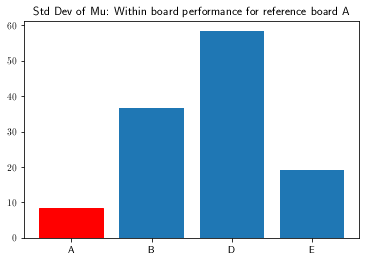

RuntimeError: latex was not able to process the following string:
b'Deviation over Power Cycle \\\\si{\\\\pico\\\\second} (ps)'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.23 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/tmp/mitao/.cache/matplotlib/tex.cache/62a28010b7e8f96149dcfcd27e4969a0.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-12>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 62a28010b7e8f96149dcfcd27e4969a0.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.19 {\sffamily Deviation over Power Cycle \si
                                              {\pico\second} (ps)}
No pages of output.
Transcript written on 62a28010b7e8f96149dcfcd27e4969a0.log.




RuntimeError: latex was not able to process the following string:
b'Deviation over Power Cycle \\\\si{\\\\pico\\\\second} (ps)'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.23 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/tmp/mitao/.cache/matplotlib/tex.cache/62a28010b7e8f96149dcfcd27e4969a0.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-12>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 62a28010b7e8f96149dcfcd27e4969a0.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.19 {\sffamily Deviation over Power Cycle \si
                                              {\pico\second} (ps)}
No pages of output.
Transcript written on 62a28010b7e8f96149dcfcd27e4969a0.log.




<Figure size 432x288 with 2 Axes>

In [19]:
example(6)